In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa

import os
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor,XGBClassifier
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

from sklearn.model_selection import KFold
from eli5.sklearn import PermutationImportance
import eli5
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from IPython.display import display

import pandas as pd
import nltk
from nltk import word_tokenize, pos_tag, sent_tokenize
from collections import Counter
import numpy as np
from math import log2

import matplotlib.pyplot as plt


# Setup
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

2025-05-06 09:08:19.434964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746522499.845107      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746522499.959907      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzippin

True

In [2]:
train_df=pd.read_csv("/kaggle/input/speech-emb/train_with_embeddings.csv")

test_df=pd.read_csv("/kaggle/input/speech-emb/test_with_embeddings.csv")
test=pd.read_csv("/kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv")
sub=pd.DataFrame(test["filename"])
sub["label"]=0

In [3]:
train_new=pd.read_csv("/kaggle/input/speech-transcription/train_transciption.csv")
test_new=pd.read_csv("/kaggle/input/speech-transcription/test_transciption.csv")

In [4]:
train_new.label.value_counts()

label
5.0    150
4.0     82
4.5     68
3.0     51
2.0     44
2.5     26
3.5     19
1.0      2
1.5      2
Name: count, dtype: int64

In [5]:
# Functions to get size and duration
def get_size_mb(path):
    return os.path.getsize(path) / (1024 * 1024)

def get_duration(path):
    try:
        duration = librosa.get_duration(path=path)
    except Exception as e:
        duration = None
    return duration

# Apply to DataFrame
# train_new['size_mb'] = train_new['filename'].apply(get_size_mb)
# train_new['duration_sec'] = train_new['filename'].apply(get_duration)
# test_new['size_mb'] = test_new['filename'].apply(get_size_mb)
# test_new['duration_sec'] = test_new['filename'].apply(get_duration)

In [6]:
train_new.filepath="/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/"+train_new.filename
test_new.filepath="/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/"+test_new.filename


In [7]:
train_df['duration_sec'] = train_new['filepath'].apply(get_duration)
test_df['duration_sec'] = test_new['filepath'].apply(get_duration)


In [8]:
X = train_df.drop(["label","filename"],axis=1)
# X=pd.DataFrame(train_df["grammar_score"])
y = train_df['label']


kf = KFold(n_splits=5, shuffle=True, random_state=1)
oof_preds_emb = np.zeros(len(train_df))
oof_test_emb = np.zeros(len(test_df))
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = XGBRegressor(n_estimators=1000, early_stopping_rounds=50, random_state=1,learning_rate=.09,subsample=.9,n_jobs=4)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=150)
    
    # Predict
    preds = model.predict(X_val)
    oof_preds_emb[val_idx] = preds
    oof_test_emb+=model.predict(test_df.drop("filename",axis=1))
    # Metrics
    rmse = mean_squared_error(y_val, preds, squared=False)
    r_val, _ = pearsonr(y_val, preds)
    print(f"Fold {fold+1}: RMSE = {rmse:.4f}, R = {r_val:.4f}")

    # xgb_importance = pd.Series(model.feature_importances_, index=X.columns)
    # display(xgb_importance.sort_values())


# -------------------- Overall Metrics --------------------
overall_rmse = mean_squared_error(y, oof_preds_emb, squared=False)
overall_r, _ = pearsonr(y, oof_preds_emb)

print(f"\nOOF RMSE: {overall_rmse:.4f}")
print(f"OOF R: {overall_r:.4f}")

train_new["oof_emb"]= oof_preds_emb
test_new["oof_emb"]= oof_test_emb/5


[0]	validation_0-rmse:0.95456
[105]	validation_0-rmse:0.75823
Fold 1: RMSE = 0.7574, R = 0.6474
[0]	validation_0-rmse:1.01269
[131]	validation_0-rmse:0.75762
Fold 2: RMSE = 0.7568, R = 0.6885
[0]	validation_0-rmse:1.10415
[150]	validation_0-rmse:0.87788
Fold 3: RMSE = 0.8777, R = 0.6435
[0]	validation_0-rmse:0.94472
[150]	validation_0-rmse:0.68771
[156]	validation_0-rmse:0.68772
Fold 4: RMSE = 0.6876, R = 0.7219
[0]	validation_0-rmse:1.06116
[150]	validation_0-rmse:0.85112
[157]	validation_0-rmse:0.85107
Fold 5: RMSE = 0.8508, R = 0.6253

OOF RMSE: 0.7889
OOF R: 0.6595


In [9]:
# !pip install textstat

In [10]:
# import re
# import string
# import numpy as np
# import pandas as pd
# import spacy
# from textstat import (
#     flesch_reading_ease, flesch_kincaid_grade, gunning_fog,
#     smog_index, automated_readability_index, coleman_liau_index
# )
# from collections import Counter
# from math import log2
# from textblob import TextBlob

# # Load spaCy model
# nlp = spacy.load("en_core_web_sm")

# # Fillers for speech disfluencies
# FILLER_WORDS = {'um', 'uh', 'erm', 'like', 'you know', 'i mean'}
# CONTRACTIONS = re.compile(r"\b(?:[a-zA-Z]+n't|'s|'re|'ll|'d|'ve|'m)\b", re.IGNORECASE)

# # Clean Text
# import re
# from collections import Counter

# def clean_text(text):
#     text = str(text).strip()
    
#     # Remove non-ASCII characters
#     ascii_text = re.sub(r'[^\x00-\x7F]+', '', text)

#     # If empty after stripping, return space
#     if not ascii_text:
#         return " "
    
#     # Count proportion of digits or non-ASCII (original, not cleaned)
#     total_chars = len(text)
#     if total_chars == 0:
#         return " "

#     if digit_or_nonascii / total_chars > 0.2:
#         return ascii_text

#     # Detect repeated words or phrases (like "I'm sorry. I'm sorry.")
#     words = ascii_text.lower().split()
#     word_counts = Counter(words)
    
#     # Check for a single word repeated many times (≥30% repetition)
#     most_common_word, freq = word_counts.most_common(1)[0]
#     # Check for full-sentence repetition
#     sentences = re.split(r'[.!?%]', ascii_text)
#     sentences = [s.strip() for s in sentences if s.strip()]
#     sentence_counts = Counter(sentences)
    
#     # Keep only sentences that occur once
#     unique_sentences = [s for s in sentences if sentence_counts[s] == 1]
    
#     ascii_text = '. '.join(unique_sentences).strip()
#     if ascii_text:
#         ascii_text += '.'
    
#     return ascii_text.strip()


# # Surface-Level Text Features
# def extract_surface_features(text):
#     words = text.split()
#     char_count = len(text)
#     word_count = len(words)
#     punctuation_count = sum(1 for c in text if c in string.punctuation)
#     digit_count = sum(w.isdigit() for w in words)
#     capital_word_count = sum(1 for w in words if w.isupper())

#     return {
#         'char_count': char_count,
#         'word_count': word_count,
#         'avg_word_len': np.mean([len(w) for w in words]) if words else 0,
#         'punctuation_count': punctuation_count,
#         'digit_count': digit_count,
#         'capital_word_count': capital_word_count
#     }

# # Lexical Diversity
# def extract_lexical_diversity_features(text):
#     words = [w.lower() for w in text.split()]
#     word_count = len(words)
#     word_freq = Counter(words)
#     unique_word_count = len(word_freq)
#     hapax_legomena_count = sum(1 for w, c in word_freq.items() if c == 1)
#     entropy = -sum(p * log2(p) for p in (freq / word_count for freq in word_freq.values())) if word_count else 0

#     return {
#         'unique_word_count': unique_word_count,
#         'type_token_ratio': unique_word_count / word_count if word_count else 0,
#         'hapax_legomena_ratio': hapax_legomena_count / word_count if word_count else 0,
#         'shannon_entropy': entropy
#     }

# # POS and Grammar Features
# def extract_syntax_pos_features(doc):
#     tokens = [t for t in doc if not t.is_punct]
#     pos_counts = Counter(t.pos_ for t in tokens)

#     return {
#         'noun_count': pos_counts['NOUN'],
#         'verb_count': pos_counts['VERB'],
#         'adj_count': pos_counts['ADJ'],
#         'adv_count': pos_counts['ADV'],
#         'pronoun_count': pos_counts['PRON'],
#         'preposition_count': pos_counts['ADP'],
#         'conjunction_count': pos_counts['CCONJ'] + pos_counts['SCONJ'],
#         'interjection_count': pos_counts['INTJ'],
#         'modal_verb_count': sum(1 for t in tokens if t.tag_ in ['MD']),
#         'coordinating_conjunction_count': sum(1 for t in tokens if t.dep_ == 'cc'),
#         'pos_diversity': len(set(t.pos_ for t in tokens)),
#     }

# # Sentence & Clause Features
# def extract_sentence_features(doc):
#     sentences = list(doc.sents)
#     tokens = [t for t in doc if not t.is_punct]

#     return {
#         'sentence_count': len(sentences),
#         'avg_sentence_length_words': len(tokens) / len(sentences) if sentences else 0,
#         'avg_sentence_length_chars': sum(len(s.text) for s in sentences) / len(sentences) if sentences else 0,
#         'noun_phrase_count': len(list(doc.noun_chunks)),
#         'verb_phrase_count': sum(1 for t in doc if t.head.pos_ == 'VERB' and t.dep_ == 'xcomp'),
#         'subordinate_clause_count': sum(1 for t in doc if t.dep_ == 'mark'),
#     }

# # Named Entity Recognition Features
# def extract_ner_features(doc):
#     ents = doc.ents
#     label_counts = Counter(ent.label_ for ent in ents)

#     features = {'named_entity_count': len(ents)}
#     for label in ['PERSON', 'ORG', 'GPE', 'DATE', 'TIME']:
#         features[f'entity_{label.lower()}_count'] = label_counts[label]
#     return features

# # Passive Voice Detection
# def extract_passive_voice(doc):
#     return {
#         'passive_voice_detected': int(any(t.dep_ == 'auxpass' for t in doc))
#     }

# # Readability Scores
# def extract_readability(text):
#     return {
#         'flesch_reading_ease': flesch_reading_ease(text),
#         'flesch_kincaid_grade': flesch_kincaid_grade(text),
#         'gunning_fog_index': gunning_fog(text),
#         'smog_index': smog_index(text),
#         'automated_readability_index': automated_readability_index(text),
#         'coleman_liau_index': coleman_liau_index(text),
#     }

# # Speech-Specific Features
# def extract_speech_features(text):
#     words = text.lower().split()
#     filler_word_count = sum(1 for w in words if w in FILLER_WORDS)
#     repetition_count = sum(1 for i in range(1, len(words)) if words[i] == words[i-1])
#     contraction_count = len(CONTRACTIONS.findall(text))

#     return {
#         'filler_word_count': filler_word_count,
#         'repetition_count': repetition_count,
#         'contraction_count': contraction_count,
#     }

# # Sentiment and Emotion (Simple Sentiment)
# def extract_sentiment_features(text):
#     tb = TextBlob(text)
#     return {
#         'sentiment_polarity': tb.sentiment.polarity,
#         'sentiment_subjectivity': tb.sentiment.subjectivity
#     }

# # Final Aggregator
# def extract_all_speech_text_features(text):
#     text = clean_text(text)
#     doc = nlp(text)

#     features = {}
#     features.update(extract_surface_features(text))
#     features.update(extract_lexical_diversity_features(text))
#     features.update(extract_syntax_pos_features(doc))
#     features.update(extract_sentence_features(doc))
#     features.update(extract_ner_features(doc))
#     features.update(extract_passive_voice(doc))
#     features.update(extract_readability(text))
#     features.update(extract_speech_features(text))
#     features.update(extract_sentiment_features(text))

#     return features

# # Example usage on a DataFrame

# grammar_features = train_new['transcription'].apply(extract_all_speech_text_features).apply(pd.Series)
# train_new = pd.concat([train_new, grammar_features], axis=1)



In [11]:
import re
def clean_text(text):
    text = str(text).strip()
    
    # Remove non-ASCII characters
    ascii_text = re.sub(r'[^\x00-\x7F]+', '', text)

    # If empty after stripping, return space
    if not ascii_text:
        return " "
    
    # Count proportion of digits or non-ASCII (original, not cleaned)
    total_chars = len(text)
    if total_chars == 0:
        return " "
    
    if (len(text)- len(ascii_text))/ total_chars > 0.2:
        return ascii_text

    # Detect repeated words or phrases (like "I'm sorry. I'm sorry.")
    words = ascii_text.lower().split()
    word_counts = Counter(words)
    
    # Check for a single word repeated many times (≥30% repetition)
    most_common_word, freq = word_counts.most_common(1)[0]
    # Check for full-sentence repetition
    sentences = re.split(r'[.!?%]', ascii_text)
    sentences = [s.strip() for s in sentences if s.strip()]
    sentence_counts = Counter(sentences)
    
    # Keep only sentences that occur once
    unique_sentences = [s for s in sentences if sentence_counts[s] == 1]
    
    ascii_text = '. '.join(unique_sentences).strip()
    if ascii_text:
        ascii_text += '.'
    
    return ascii_text.strip()
train_new.transcription=train_new.transcription.apply(clean_text)
test_new.transcription=test_new.transcription.apply(clean_text)

In [12]:
train_new

,filename,label,filepath,transcription,oof_emb
0,audio_710.wav,1.0,/kaggle/input/shl-intern-hiring-assessment/Dat...,Welcome to India. You show your hair represent...,3.411086
1,audio_1265.wav,1.0,/kaggle/input/shl-intern-hiring-assessment/Dat...,"My favorite hobby is cultivation of plants, su...",2.897266
2,audio_1114.wav,1.5,/kaggle/input/shl-intern-hiring-assessment/Dat...,My goal is to become an electrical employee an...,2.869756
3,audio_946.wav,1.5,/kaggle/input/shl-intern-hiring-assessment/Dat...,The playground looks like very clear and neat ...,2.323311
4,audio_1127.wav,2.0,/kaggle/input/shl-intern-hiring-assessment/Dat...,My goal is to bring my parents to live with me...,3.076846
...,...,...,...,...,...
439,audio_613.wav,5.0,/kaggle/input/shl-intern-hiring-assessment/Dat...,Sorry. Because. I can't do this to you. I can'...,4.667515
440,audio_1002.wav,5.0,/kaggle/input/shl-intern-hiring-assessment/Dat...,"In a backdrop of a school, you might see Vasel...",4.331343
441,audio_1058.wav,5.0,/kaggle/input/shl-intern-hiring-assessment/Dat...,"My favourite place to visit is Palm Springs, C...",4.882990
442,audio_250.wav,5.0,/kaggle/input/shl-intern-hiring-assessment/Dat...,One of my favourite hobbies is to repurpose cl...,4.200172


In [13]:
def shannon_entropy(freq_dict):
    total = sum(freq_dict.values())
    return -sum((count / total) * log2(count / total) for count in freq_dict.values() if count > 0) if total > 0 else 0

def estimate_parse_depth(sent):
    tokens = word_tokenize(sent)
    return min(len(tokens), 10)  # proxy: longer sentence → deeper tree

def estimate_clause_count(sent):
    return sent.count(',') + sent.count('because') + sent.count('that') + sent.count('which')

def extract_float_features(text):
    features = {}

    # Tokenize
    sentences = sent_tokenize(text)
    words = word_tokenize(text)
    word_count = len(words)
    sentence_count = len(sentences)
    unique_word_count = len(set(words))

    # Lexical features
    features['word_count'] = word_count
    features['unique_word_count'] = unique_word_count
    features['type_token_ratio'] = unique_word_count / word_count if word_count else 0
    features['avg_word_length'] = np.mean([len(w) for w in words]) if words else 0
    features['sentence_count'] = sentence_count
    features['avg_sentence_length'] = word_count / sentence_count if sentence_count else 0

    # Entropy features
    word_freq = Counter(words)
    char_freq = Counter("".join(words))
    pos_tags = [tag for _, tag in pos_tag(words)]
    pos_freq = Counter(pos_tags)

    features['word_entropy'] = shannon_entropy(word_freq)
    features['char_entropy'] = shannon_entropy(char_freq)
    features['pos_entropy'] = shannon_entropy(pos_freq)

    # POS tag counts (normalized)
    total_pos = sum(pos_freq.values())
    for tag in ['NN', 'VB', 'JJ', 'RB', 'PRP', 'IN', 'DT']:
        features[f'pos_freq_{tag}'] = pos_freq[tag] / total_pos if total_pos else 0

    # Estimated parse depth and clause count
    parse_depths = [estimate_parse_depth(s) for s in sentences]
    features['avg_parse_tree_depth'] = np.mean(parse_depths) if parse_depths else 0
    features['clause_count'] = sum(estimate_clause_count(s) for s in sentences)

    return features

def process_dataframe(df, column='transcription'):
    feature_dicts = df[column].apply(extract_float_features)
    feature_df = pd.DataFrame(feature_dicts.tolist()).astype('float32')
    return pd.concat([df.reset_index(drop=True), feature_df], axis=1)


# train_new = process_dataframe(train_new)
# test_new = process_dataframe(test_new)

In [14]:
cat=list(train_new.select_dtypes("object").columns)
cat

['filename', 'filepath', 'transcription']

In [15]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load tokenizer + model
deberta_model_name = 'microsoft/deberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(deberta_model_name)
model = AutoModel.from_pretrained(deberta_model_name)
model.eval()

def get_deberta_embeddings(texts, batch_size=4, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts, padding=True, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = model(**encoded)
            # Mean pooling over token embeddings (excluding padding)
            attention_mask = encoded['attention_mask'].unsqueeze(-1)
            token_embeddings = outputs.last_hidden_state
            summed = torch.sum(token_embeddings * attention_mask, dim=1)
            count = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
            mean_pooled = summed / count
            embeddings.append(mean_pooled.cpu().numpy())

    return np.vstack(embeddings)

def add_text_embeddings_deberta(df, text_col='transcription'):
    texts = df[text_col].fillna("").astype(str).tolist()
    emb = get_deberta_embeddings(texts)
    emb_cols = [f'{text_col}_deberta_emb_{i}' for i in range(emb.shape[1])]
    emb_df = pd.DataFrame(emb, columns=emb_cols, index=df.index)
    return pd.concat([df.reset_index(drop=True), emb_df.reset_index(drop=True)], axis=1)

train_new=add_text_embeddings_deberta(train_new)
test_new=add_text_embeddings_deberta(test_new)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]


100%|██████████| 51/51 [00:03<00:00, 14.14it/s]


In [16]:
# Step 1: Initial setup
# sub["label"]=0
# train_new1=train_new.copy()
# X = train_new1.drop(["label", "filename", "transcription"] + cat, axis=1)
# y = train_new1['label']

# test_new = test_new.drop(["filename", "transcription"] + cat, axis=1)

# kf = KFold(n_splits=5, shuffle=True, random_state=1)
# oof_preds = np.zeros(len(X))
# feature_importance_accum = pd.Series(0, index=X.columns, dtype=float)
# perm_importance_list = []

# Step 2: Cross-validation with all features
# for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
#     model = XGBRegressor(n_estimators=1000, early_stopping_rounds=100, random_state=1, subsample=0.9, learning_rate=0.05,n_jobs=4)
#     model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
    
#     preds = model.predict(X_val)
#     sub["label"]+= model.predict(test_new)
#     oof_preds[val_idx] = preds
    
#     rmse = mean_squared_error(y_val, preds, squared=False)
#     r_val, _ = pearsonr(y_val, preds)
#     print(f"Fold {fold+1}: RMSE = {rmse:.4f}, R = {r_val:.4f}")

    # feature_importance_accum += pd.Series(model.feature_importances_, index=X.columns)

    # perm = PermutationImportance(model, random_state=1, scoring='neg_root_mean_squared_error').fit(X_val, y_val)
    # perm_df = eli5.explain_weights_df(perm, feature_names=X.columns.tolist())
    # perm_importance_list.append(perm_df.set_index('feature')['weight'])

# # Step 3: Aggregate importances
# avg_model_importance = feature_importance_accum / kf.get_n_splits()
# avg_perm_importance = pd.concat(perm_importance_list, axis=1).mean(axis=1).sort_values(ascending=False)

# print("\nAverage Model-based Importance:")
# display(avg_model_importance.sort_values(ascending=False).to_frame("importance").head(20))

# print("\nAverage Permutation Importance:")
# display(avg_perm_importance.to_frame("importance").head(20))

# unneeded_columns = avg_perm_importance[avg_perm_importance < 0].index.tolist()
# print("\nUnneeded columns (avg perm importance < 0):")
# print(unneeded_columns)

# Step 4: Drop unneeded columns and retrain
# X = X.drop(columns=unneeded_columns)
# oof_preds = np.zeros(len(X))

# for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
#     model = XGBRegressor(n_estimators=1000, early_stopping_rounds=150, random_state=1, subsample=0.85, learning_rate=0.05)
#     model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
    
#     preds = model.predict(X_val)
#     oof_preds[val_idx] = preds
    
#     rmse = mean_squared_error(y_val, preds, squared=False)
#     r_val, _ = pearsonr(y_val, preds)
#     print(f"[Reduced] Fold {fold+1}: RMSE = {rmse:.4f}, R = {r_val:.4f}")

# # Step 5: Final metrics
# overall_rmse = mean_squared_error(y, oof_preds, squared=False)
# overall_r, _ = pearsonr(y, oof_preds)
# print(f"\n OOF RMSE: {overall_rmse:.4f}")
# print(f" OOF R: {overall_r:.4f}")

# # Step 6: Partial Dependence Plots
# final_model = XGBRegressor(n_estimators=1000, random_state=1, subsample=0.85, learning_rate=0.1)
# final_model.fit(X, y)

# features = list(X.columns)
# fig, ax = plt.subplots(nrows=int(np.ceil(len(features) / 3)), ncols=3, figsize=(20, len(features) * 1.5))
# ax = ax.flatten()[:len(features)]
# PartialDependenceDisplay.from_estimator(final_model, X, features, ax=ax)
# plt.tight_layout()
# plt.show()


In [17]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation

# Prepare data
train_new1 = train_new.copy()
X = train_new1.drop(["label", "filename", "transcription"] + cat, axis=1)
y = train_new1['label']
test_new = test_new.drop(["filename", "transcription"] + cat, axis=1)

# KFold setup
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Models to train
models = {
    'xgb': XGBRegressor(n_estimators=1000, early_stopping_rounds=100, random_state=1, subsample=0.9, learning_rate=0.05, n_jobs=4),
    'catboost': CatBoostRegressor(n_estimators=1000, learning_rate=0.05, random_seed=1, early_stopping_rounds=100, verbose=0),
    'lgbm': LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=1, subsample=0.9,n_jobs=4)
}

oof_preds_all = {}
test_preds_all = {}

# Training loop
for model_name, model in models.items():
    print(f"\nTraining model: {model_name.upper()}")
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(test_new))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        if model_name == "catboost":
            model.fit(X_train, y_train, eval_set=(X_val, y_val))
        elif model_name == "lgbm":
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                callbacks=[early_stopping(stopping_rounds=100), log_evaluation(50)]
            )
        else:  # XGBoost
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)

        preds = model.predict(X_val)
        test_preds += model.predict(test_new) / kf.n_splits
        oof_preds[val_idx] = preds

        rmse = mean_squared_error(y_val, preds, squared=False)
        r_val, _ = pearsonr(y_val, preds)
        print(f"Fold {fold+1}: RMSE = {rmse:.4f}, R = {r_val:.4f}")

    overall_rmse = mean_squared_error(y, oof_preds, squared=False)
    overall_r, _ = pearsonr(y, oof_preds)
    print(f"\n{model_name.upper()} OOF RMSE: {overall_rmse:.4f}")
    print(f"{model_name.upper()} OOF R: {overall_r:.4f}")

    oof_preds_all[model_name] = oof_preds
    test_preds_all[model_name] = test_preds



Training model: XGB
[0]	validation_0-rmse:0.96361
[50]	validation_0-rmse:0.64800
[100]	validation_0-rmse:0.64315
[150]	validation_0-rmse:0.64330
[196]	validation_0-rmse:0.64343
Fold 1: RMSE = 0.6420, R = 0.7605
[0]	validation_0-rmse:1.00687
[50]	validation_0-rmse:0.64440
[100]	validation_0-rmse:0.65093
[150]	validation_0-rmse:0.65644
[166]	validation_0-rmse:0.65741
Fold 2: RMSE = 0.6443, R = 0.7877
[0]	validation_0-rmse:1.10038
[50]	validation_0-rmse:0.81779
[100]	validation_0-rmse:0.83845
[136]	validation_0-rmse:0.84552
Fold 3: RMSE = 0.8112, R = 0.6990
[0]	validation_0-rmse:0.96003
[50]	validation_0-rmse:0.68236
[100]	validation_0-rmse:0.66868
[150]	validation_0-rmse:0.66820
[200]	validation_0-rmse:0.66826
[250]	validation_0-rmse:0.66858
[281]	validation_0-rmse:0.66874
Fold 4: RMSE = 0.6677, R = 0.7414
[0]	validation_0-rmse:1.06003
[50]	validation_0-rmse:0.72358
[100]	validation_0-rmse:0.70891
[150]	validation_0-rmse:0.70894
[200]	validation_0-rmse:0.70897
[216]	validation_0-rmse:0.

In [18]:
# === Final Ensemble: OOF and Test Predictions ===
# Average ensemble of OOF predictions
ensemble_oof = (
    oof_preds_all['xgb'] +
    oof_preds_all['catboost'] +
    oof_preds_all['lgbm']
) / 3

# Average ensemble of Test predictions
ensemble_test = (
    test_preds_all['xgb'] +
    test_preds_all['catboost'] +
    test_preds_all['lgbm']
) / 3
# Final OOF performance
overall_rmse = mean_squared_error(y, ensemble_oof, squared=False)
overall_r, _ = pearsonr(y, ensemble_oof)

print(f"\nFINAL ENSEMBLED OOF RMSE: {overall_rmse:.4f}")
print(f"FINAL ENSEMBLED OOF R: {overall_r:.4f}")

# Optional: Assign ensemble test predictions to submission file
sub["label"] = ensemble_test


FINAL ENSEMBLED OOF RMSE: 0.6752
FINAL ENSEMBLED OOF R: 0.7658


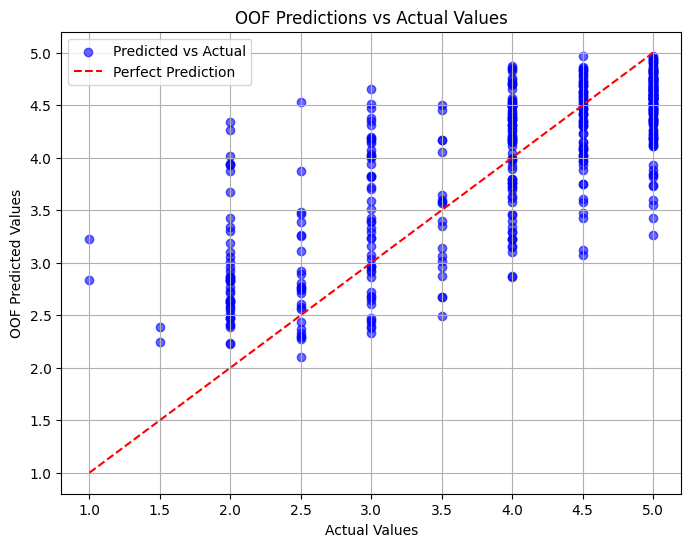

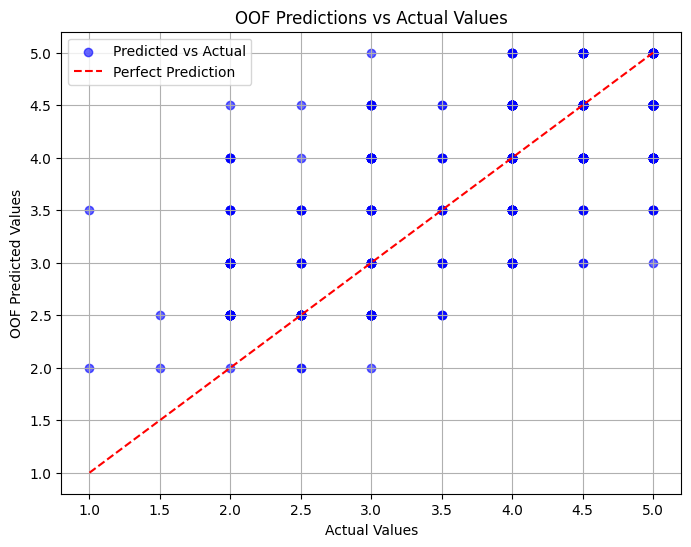

In [19]:
y_true = train_new.label  # Actual target values
y_oof = ensemble_oof   
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_oof, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfect Prediction')

plt.title('OOF Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('OOF Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

y_oof = (oof_preds*2).round()/2   
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_oof, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfect Prediction')

plt.title('OOF Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('OOF Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
sub.to_csv("sub.csv",index=False)
sub

,filename,label
0,audio_804.wav,2.660213
1,audio_1028.wav,2.550891
2,audio_865.wav,2.599402
3,audio_774.wav,2.586090
4,audio_1138.wav,3.465830
...,...,...
199,audio_787.wav,4.840777
200,audio_1079.wav,4.851412
201,audio_550.wav,4.225530
202,audio_641.wav,4.667898


# Potenital Issue with Data Leakage (index) 

In [21]:
sub["label"]=0

In [22]:
train_new1 = train_new.copy()
train_new1["index"]=list(train_new1.index)
X = train_new1.drop(["label", "filename", "transcription"] + cat, axis=1)
y = train_new1['label']
test_new["index"]=list(test_new.index*1.5)

# KFold setup
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Models to train
models = {
    'xgb': XGBRegressor(n_estimators=1000, early_stopping_rounds=100, random_state=1, subsample=0.9, learning_rate=0.05, n_jobs=4),
    'catboost': CatBoostRegressor(n_estimators=1000, learning_rate=0.05, random_seed=1, early_stopping_rounds=100, verbose=0),
    'lgbm': LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=1, subsample=0.9,n_jobs=4)
}

oof_preds_all = {}
test_preds_all = {}

# Training loop
for model_name, model in models.items():
    print(f"\nTraining model: {model_name.upper()}")
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(test_new))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        if model_name == "catboost":
            model.fit(X_train, y_train, eval_set=(X_val, y_val))
        elif model_name == "lgbm":
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                callbacks=[early_stopping(stopping_rounds=100), log_evaluation(50)]
            )
        else:  # XGBoost
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)

        preds = model.predict(X_val)
        test_preds += model.predict(test_new) / kf.n_splits
        oof_preds[val_idx] = preds

        rmse = mean_squared_error(y_val, preds, squared=False)
        r_val, _ = pearsonr(y_val, preds)
        print(f"Fold {fold+1}: RMSE = {rmse:.4f}, R = {r_val:.4f}")

    overall_rmse = mean_squared_error(y, oof_preds, squared=False)
    overall_r, _ = pearsonr(y, oof_preds)
    print(f"\n{model_name.upper()} OOF RMSE: {overall_rmse:.4f}")
    print(f"{model_name.upper()} OOF R: {overall_r:.4f}")

    oof_preds_all[model_name] = oof_preds
    test_preds_all[model_name] = test_preds



Training model: XGB
[0]	validation_0-rmse:0.94126
[50]	validation_0-rmse:0.21993
[100]	validation_0-rmse:0.20394
[150]	validation_0-rmse:0.20511
[184]	validation_0-rmse:0.20525
Fold 1: RMSE = 0.2031, R = 0.9789
[0]	validation_0-rmse:0.99240
[50]	validation_0-rmse:0.25886
[100]	validation_0-rmse:0.24114
[150]	validation_0-rmse:0.24027
[200]	validation_0-rmse:0.24013
[250]	validation_0-rmse:0.24012
[300]	validation_0-rmse:0.24011
[350]	validation_0-rmse:0.24011
[360]	validation_0-rmse:0.24011
Fold 2: RMSE = 0.2401, R = 0.9733
[0]	validation_0-rmse:1.07220
[50]	validation_0-rmse:0.25710
[100]	validation_0-rmse:0.23450
[150]	validation_0-rmse:0.23401
[200]	validation_0-rmse:0.23397
[250]	validation_0-rmse:0.23394
[293]	validation_0-rmse:0.23394
Fold 3: RMSE = 0.2339, R = 0.9784
[0]	validation_0-rmse:0.94305
[50]	validation_0-rmse:0.24874
[100]	validation_0-rmse:0.23947
[150]	validation_0-rmse:0.23954
[200]	validation_0-rmse:0.23961
[202]	validation_0-rmse:0.23961
Fold 4: RMSE = 0.2394, R 

In [23]:
# === Final Ensemble: OOF and Test Predictions ===
# Average ensemble of OOF predictions
ensemble_oof = (
    oof_preds_all['xgb'] +
    oof_preds_all['catboost'] +
    oof_preds_all['lgbm']
) / 3

# Average ensemble of Test predictions
ensemble_test = (
    test_preds_all['xgb'] +
    test_preds_all['catboost'] +
    test_preds_all['lgbm']
) / 3
# Final OOF performance
overall_rmse = mean_squared_error(y, ensemble_oof, squared=False)
overall_r, _ = pearsonr(y, ensemble_oof)

print(f"\nFINAL ENSEMBLED OOF RMSE: {overall_rmse:.4f}")
print(f"FINAL ENSEMBLED OOF R: {overall_r:.4f}")

# Optional: Assign ensemble test predictions to submission file
sub["label"] = ensemble_test


FINAL ENSEMBLED OOF RMSE: 0.2396
FINAL ENSEMBLED OOF R: 0.9743


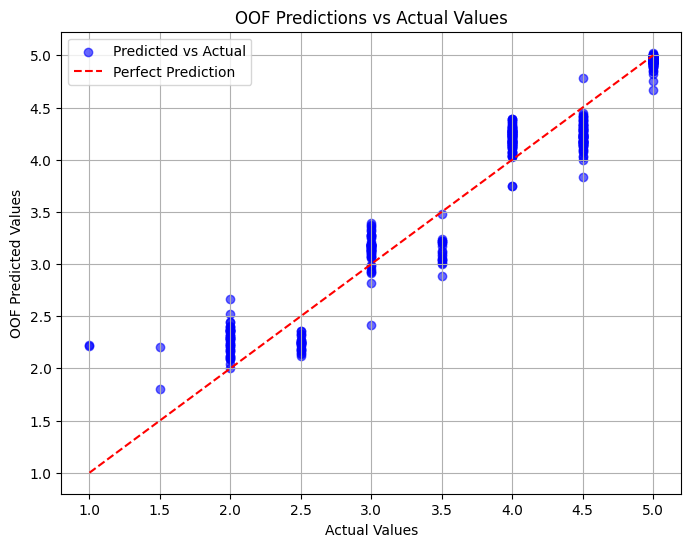

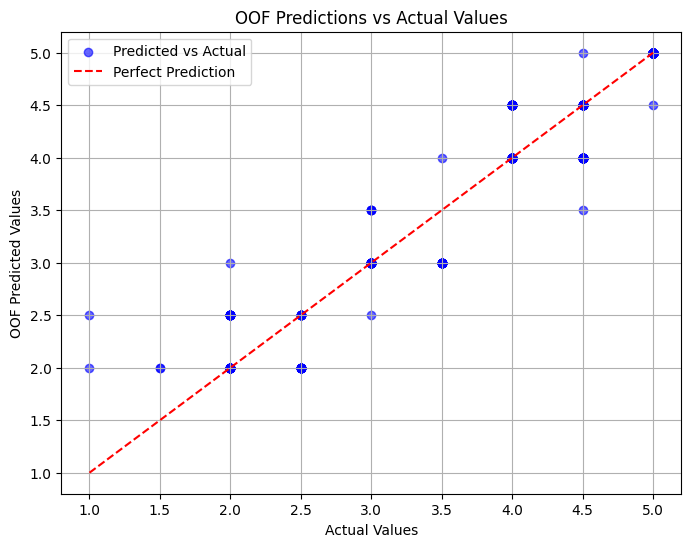

In [24]:
y_true = train_new.label  # Actual target values
y_oof = ensemble_oof   
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_oof, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfect Prediction')

plt.title('OOF Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('OOF Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

y_oof = (oof_preds*2).round()/2   
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_oof, color='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Perfect Prediction')

plt.title('OOF Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('OOF Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
sub["label"]=sub["label"].clip(upper=5)
sub.to_csv("sub_with_leakage.csv",index=False)
sub

,filename,label
0,audio_804.wav,2.074344
1,audio_1028.wav,2.094710
2,audio_865.wav,2.077210
3,audio_774.wav,2.216077
4,audio_1138.wav,2.214478
...,...,...
199,audio_787.wav,4.949005
200,audio_1079.wav,4.962833
201,audio_550.wav,4.927999
202,audio_641.wav,4.954481
